In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('mnist_train.csv')
df_test = pd.read_csv('mnist_test.csv')

df_train

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
train = df_train.to_numpy()
test = df_test.to_numpy()

X_train = train[:, 1:] / 255
y_train = train[:,[0]]
X_test = test[:, 1:] / 255
y_test = test[:,[0]] 

m = len(X_train)
n = len(X_train[0])

y_train.shape

(60000, 1)

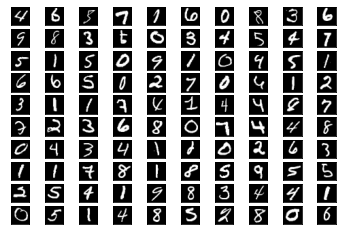

In [4]:
# visualize some images
fig, ax = plt.subplots(nrows=10, ncols=10)

for row in ax:
    for col in row:
        # reshape image
        img = X_train[np.random.randint(0, len(X_train))]
        
        #the float values go by columns, not rows; ie. the first 20 values make up the first COLUMN
        img = img.reshape(28, 28)
            
        col.axes.get_xaxis().set_visible(False)
        col.axes.get_yaxis().set_visible(False)
        col.imshow(img, cmap='gray')

plt.show()

In [5]:
lam = 0.5
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))


# aka forward propagation
# input: matrix in inputs; weight_matrices: weights
# prediction function for the neural net (either 1 or many predictions); should not contain the bias unit

def net_outputs(inputs, weight_matrices):

    predictions = []
    activation_list = []
    
    activations = np.asarray(inputs).T
    for wt in weight_matrices:
        
        # add on the bias unit to the vector
        activations = np.concatenate(([[1] * len(inputs)], activations), axis=0)
        
        activation_list.append(activations)
            
        #calculate the activations of the next layer
        activations = sigmoid(np.dot(wt, activations))
        
    activation_list.append(activations)
    
    # return the drawn number if specified; return column of numbers
    # if return_number:
    #    return np.asarray([[np.argmax(row)] for row in activations.T])
        
    # last element is matrix in which the COLUMNS represesent the output values of each respective training example
    return activation_list
            

# function for computing the cost of the neural net
# y_train: column matrix of values
def nnet_cost(weight_matrices, y_train):
    
    # derive a y (m by k) matrix where each row contain the correct classification labels 
    # (0 for all incorrect, and 1 for correct), as opposed to a single number
    
    y_with_vectors = []
    m = len(y_train)
    k = len(set(y_train.flatten()))
    for value in y_train:
        new_label = np.where(np.arange(k) == value[0], 1, 0)
        y_with_vectors.append(new_label)
        
    y_with_vectors = np.asarray(y_with_vectors)
        
    # k by m matrix of output values
    outputs = net_outputs(X_train, weight_matrices)[-1]
    
    logsum = (-1 / m) * np.sum(np.multiply(y_with_vectors, np.log(outputs).T) + np.multiply(1 - y_with_vectors, np.log(1 - outputs).T))
    regul = (lam / (2 * m)) * np.sum([np.sum(t[:,1:] ** 2) for t in weight_matrices])
    
    return logsum + regul
    
    
# loops through all examples and returns the gradient (vectorized), as well as the errors of the input layer
def gradient(weight_matrices, activations=None):
    
    # set all values to zero; this serves to accumate gradient adjustments for each training example;
    grad_accumulator = np.asarray([np.zeros(wt.shape) for wt in weight_matrices])
    
    if activations is None:
        activations = net_outputs(X_train, weight_matrices)
    outvals = activations[-1]
    
    # make a matrix to contain y vector labels in each column of the matrix (corresponding to each training example)
    k = len(set(y_train.flatten()))
    y_labels = np.asarray([np.where(np.arange(k) == y_train[i][0], 1, 0) for i in range(len(y_train))]).T
    
    # backprop errors; stored in a list of matrices, where the position of the matrix in the list corresponds to the layer
    # and the columns of the matrix correspond to a particular training example
    errors = [outvals - y_labels]
    
    # calculate errors
    for iteration, i in enumerate(reversed(range(len(weight_matrices)))):
        wt = weight_matrices[i]
        activation = activations[-2 - iteration]
        
        next_error = np.dot(wt.T, errors[-1]) * activation * (1 - activation)
        errors.append(next_error[1:, :])
        
    errors = np.asarray(list(reversed(errors)))

    # vectorized over all training examples; accumulate changes
    for layer in range(len(grad_accumulator)):
        grad_accumulator[layer] += np.dot(errors[layer + 1], activations[layer].T)
    
    # todo compute gradient with the accumulator (works)
    for ma in range(len(grad_accumulator)):
        current = grad_accumulator[ma]
        grad_accumulator[ma] = np.concatenate((current[:,[0]], current[:, 1:] + lam * weight_matrices[ma][:, 1:]), axis=1)
        
    return (1 / m) * grad_accumulator, errors[0]
    

In [10]:
initial_mag = np.sqrt(6) / np.sqrt(n + 10)
layersizes = [784, 49, 10]

initial_weights = []
for i in range(len(layersizes) - 1):
    initial_weights.append(np.random.uniform(-initial_mag, initial_mag, (layersizes[i + 1], 1 + layersizes[i])))

initial_weights = np.asarray(initial_weights)

weights = initial_weights.copy()
optim_grad, _ = gradient(weights)

alpha = 1.0
max_iter = 200
train_accs = []
test_accs = []
lam = 1
epochs = list(range(0, max_iter))
for i in range(max_iter):
    
    # training prediction
    activations = net_outputs(X_train, weights)
    preds = activations[-1]
    
    # get the chosen number output (rather than probabilities)
    preds = np.asarray([[np.argmax(row)] for row in preds.T])
    truths = np.where(np.equal(preds, y_train), 1, 0)
    accuracy = np.sum(truths) / (len(truths))
    train_accs.append(accuracy)

    # testing prediction
    preds = net_outputs(X_test, weights)[-1]
    preds = np.asarray([[np.argmax(row)] for row in preds.T])
    truths = np.where(np.equal(preds, y_test), 1, 0)
    accuracy = np.sum(truths) / (len(truths))
    test_accs.append(accuracy)
            
    for matr in range(len(optim_grad)):
        weights[matr] -= alpha * optim_grad[matr]

    optim_grad, input_error = gradient(weights, activations)
        

0.8937
0.8867833333333334


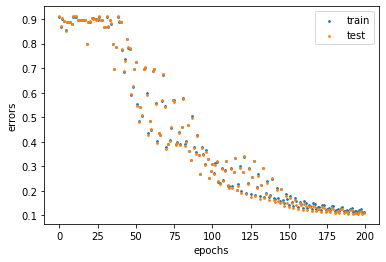

In [11]:
plt.figure()
train_accs = np.asarray(train_accs)
test_accs = np.asarray(test_accs)
plt.scatter(epochs, 1 - train_accs, s=3, label='train')
plt.scatter(epochs, 1 - test_accs, s=3, label='test')
plt.legend()
plt.ylabel('errors')
plt.xlabel('epochs')

print(np.max(test_accs))
print(np.max(train_accs))

In [12]:
preds = net_outputs(X_train, weights)[-1]
preds = np.asarray([[np.argmax(row)] for row in preds.T])
truths = np.where(np.equal(preds, y_train), 1, 0)
accuracy = np.sum(truths) / m
print('training accuracy: ' + str(accuracy))

preds = net_outputs(X_test, weights)[-1]
preds = np.asarray([[np.argmax(row)] for row in preds.T])
truths = np.where(np.equal(preds, y_test), 1, 0)
accuracy = np.sum(truths) / len(y_test)
print('testing accuracy: ' + str(accuracy))

training accuracy: 0.8843
testing accuracy: 0.8916


In [13]:
# save theta values to a text file

with open('weights2.txt', 'w') as file:
    for matr in weights:
        num_rows, num_cols = matr.shape
        file.write(str(num_rows) + ';' + str(num_cols))
        file.write('\n')
        
        for row in matr:
            for val in row:
                file.write(str(val) + ',')
        
        file.write('\n')

[[3]]
[3]


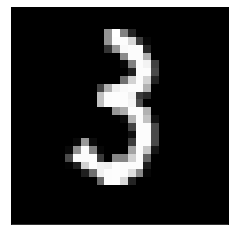

In [14]:
# load weights
weights = []

dims = None
with open('weights2.txt', 'r') as file:
    for line in file:
        if ';' in line:
            dims = tuple([int(dim.strip()) for dim in line.split(';')])

        else:
            values = np.asarray([[float(val.strip()) for val in line.split(',')[:-1]]])
            weights.append(values.reshape(dims))

weights = np.asarray(weights)

index = 1234
prediction = net_outputs([X_train[index]], weights)[-1]
prediction = np.asarray([[np.argmax(row)] for row in prediction.T])
print(prediction)
print(y_train[index])
            
fig, ax = plt.subplots(nrows=1, ncols=1)
img = X_train[index]
img = img.reshape(28, 28)
            
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.imshow(img, cmap='gray')